In [1]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [2]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

To build a neural network in PyTorch, we use the torch.nn package, which we gave the alias nn when we imported it earlier. This package contains all of the typical components needed to build neural networks.

Within the nn package, there is a class called Module. Module is the base class for all neural network modules, and so our network and all of its layers will extend the nn.Module class.

We define our DQN as a class that extends nn.Module. Our DQN will receive screenshot-like images of the cart and pole environment as input. So to create a DQN object, we’ll require the height and width of the image input that will be coming in to this model. 

__ init__ is a constructor( parameterized constructor here) in python. So it is a reserved method inside a class

For any particular image tensor(nd-array in pytorch), t, passed to the network, t will first need to be flattened before it can be passed to the first fully connected layer. After this, t will be passed to the fully connected layer and then have relu applied to it. Then, this result will be passed to the second fully connected layer, and again have relu applied. This result will then be passed to the output player. The result from the output layer will be returned by the forward() function.
or __forward()__ fucntion is used to get output from input tensor of nn in pytorch

In [3]:
class DQN(nn.Module):
    def __init__(self, img_height, img_width):
        super().__init__()
        self.fc1 = nn.Linear(in_features=img_height*img_width*3, out_features=24)   
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=2)
    
    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

Experience is a class which calls namedtuple function to create an object with name/title "experience" and feilds s,a,r,ns

In [ ]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

ReplayMemory class is used to store the experiences.

We also create a push_count attribute, which we initialize to 0, and we’ll use this to keep track of how many experiences we’ve added to memory.

Push function is used to add/store new experiences into the replay memory. If it is full, we replace the oldest experince with the new experience.

We also want to be able to sample experiences from replay memory. These sampled experiences will be what we use to train our DQN. We define this sample() function, which returns a random sample of experiences. The number of randomly sampled experiences returned will be equal to the batch_size parameter passed to the function.

In [5]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

To get a balance of exploration and exploitation, we use what we previously introduced as an __epsilon greedy strategy__. With this strategy, we define an __exploration rate called epsilon__ that we initially set to 1. This exploration rate is the probability that our agent will explore the environment rather than exploit it.

Our EpsilonGreedyStrategy accepts start, end, and decay, which correspond to the starting, ending, and decay values of epsilon. These attributes all get initialized based on the values that are passed in during object creation. 

Get exploration rate finds the decayed value of exploration rate after a step for the next step.

In [6]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
        
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * math.exp(-1. * current_step * self.decay)#

Agent class implements the agent which takes decisions in our environment. It requires a strategy(which is greedy epsilon in our case) and number of actions it can take(which is 2 in our case).

Select action fucntion is used by the agent to decide the next action from the current state. So it requires a state and a policy network(deep Q network) from where it will select the Q values.

We’re specifying with torch.no_grad() before we pass data to our policy_net to turn off gradient tracking since we’re currently using the model for inference and not training. During training PyTorch keeps track of all the forward pass calculations that happen within the network. It needs to do this so that it can know how to apply backpropagation later. Since we’re only using the model for inference at the moment, we’re telling PyTorch not to keep track of any forward pass calculations.

device will be the device that we tell PyTorch to use for tensor calculations, i.e. a CPU or GPU.

In [7]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
    
    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1
        
        if random.random() < rate:
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device) # explore      
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(self.device) # exploit

__CartPoleEnvManager__ class will manage our cart and pole environment. It will wrap several of gym’s environment capabilities, and it will also give us some added functionality,like image preprocessing, for the environment images that will be given to our network as input. 

To create a CartPoleEnvManager object, we just require a device be passed to the constructor. 

Since we must __reset()__ the environment to get an initial observation of it, we do this right after initializing env. We then set the current_screen attribute equal to None. When it’s set to None, that indicates that we’re at the start of an episode and have not yet rendered the screen of the initial observation.

When we reset the environment, we’re typically going to be at the end of an episode, and therefore, we want to set the current_screen back to None since this indicates that we’re at the start of an episode and have not yet rendered the screen of the initial observation. 

We call __render()__ on the environment to render the current state to the screen.

We’re wrapping these functions in this way so that later, in our main program, we’ll only have to deal with a CartPoleEnvManager, and not both this manager and an environment. We’re encapsulating the environment functionality within our environment manager, so that our manager can completely manage the environment using these functions as well as other fucntions which will give our code a cleaner interface.

__num_actions_available__ returns the number of actions that are available for the agent in the environment.

__take_action()__ is a function that requires an action to be passed in it. Using this action, we call step() on the environment, which will execute the given action taken by the agent in the environment. 
step() returns a tuple containing the environment observation, reward, whether or not the episode ended, and diagnostic info, all of which resulted from the agent executing that particular action. Notice that we’re calling item() on the action we’re passing to step(). This is because the action that will be passed to this function in our main program will be a tensor. We’ll be consistently working with tensors throughout the main program. item() just returns the value of this tensor as a standard Python number, which is what step() expects. 

We will represent a single state in the environment as the difference between the current screen and the previous screen. This will allow the agent to take the velocity of the pole into account from one single image. So, a single state will be represented as a processed image of the difference between two consecutive screens.

when we’re at the start of a new episode, there is no last screen to compare to the current screen. So, we’re going to represent our starting state with a fully black screen. 



In [8]:
class CartPoleEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
    
    def reset(self):
        self.env.reset()
        self.current_screen = None

    def close(self):
        self.env.close()

    def render(self, mode='human'):
        return self.env.render(mode)
    
    def num_actions_available(self):
        return self.env.action_space.n
    
    def take_action(self, action):        
        _, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)
    
    def just_starting(self):
        return self.current_screen is None
    
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2, 0, 1)) # PyTorch expects CHW
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
        
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]

    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    def crop_screen(self, screen):
        screen_height = screen.shape[1]
        # Strip off top and bottom
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen
    
    def transform_screen_data(self, screen):       
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)

        # Use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage()
            ,T.Resize((40,90))
            ,T.ToTensor()
        ])

        return resize(screen).unsqueeze(0).to(self.device) # add a batch dimension (BCHW)

Non-processed Screen

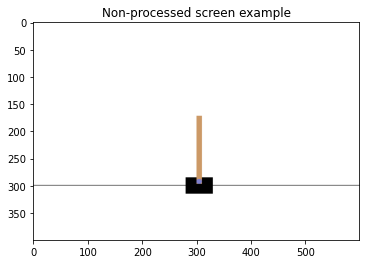

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
em.reset()
screen = em.render('rgb_array')

plt.figure()
plt.imshow(screen)
plt.title('Non-processed screen example')
plt.show()

Processed Screen

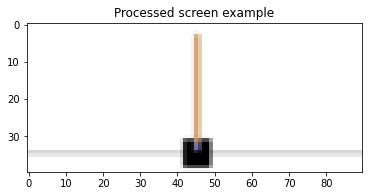

In [32]:
screen = em.get_processed_screen()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Processed screen example')
plt.show()

Utility Functions:

In [9]:
#Function to plot
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)

    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)    
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
        moving_avg_period, "episode moving avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)

In [10]:
# We’ll also want to plot the 100 episode moving average, so we do 
# so by calling the function get_moving_average(), which accepts 
# the moving_average_period and the values for which it will be calculating the moving average from. 

def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

Hyperparameters

In [12]:
batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 1000

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

In [15]:
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

 Now, we define both our policy network and target network by creating two instances of our DQN class and passing in the height and width of the screen to set up the appropriate input shape of the networks. We put these networks on our defined device using PyTorch’s to() function.



In [16]:
policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)

We then set the weights and biases in the target_net to be the same as those in the policy_net using PyTorch’s state_dict() and load_state_dict() functions. We also put the target_net into eval mode, which tells 
PyTorch that this network is not in training mode. In other words, this network will only be used for inference. 

In [17]:
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (fc1): Linear(in_features=10800, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=2, bias=True)
)

In [18]:
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

In [19]:
episode_durations = []

In [20]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod        
    def get_next(target_net, next_states):                
        final_state_locations = next_states.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

In [21]:
def extract_tensors(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))

    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)

    return (t1,t2,t3,t4)

For each episode, we first reset the environment, then get the initial state. 

For each time step, our agent selects an action based on the current state. Recall, we also need to pass in the required policy_net since the agent will use this network to select it’s action if it exploits the environment rather than explores it.

The agent then takes the chosen action and receives the associated reward, and we get the next_state.

We now can create an Experience using the state, action, next_state, and reward and push this onto replay memory. After which, we transition to the next state by setting our current state to next_state. 

Now that our agent has had an experience and stored it in replay memory, we’ll check to see if we can get a sample from replay memory to train our policy_net.

If we can get a sample from memory, then we get a sample equal to batch_size and assign this sample to the variable experiences. We’re then going to do some data manipulation to extract all the states, actions, rewards, and next_states into their own tensors from the experiences list. We do this using the extract_tensors() function.

Now we get the q-values for the corresponding state-action pairs that we’ve extracted from the experiences in our batch. We do this using QValues.get_current(), to which we pass our policy_net, states, and actions.

We’ll be covering the QValues class later as well, but for now, just know that get_current() will return the q-values for any given state-action pairs, as predicted from the policy network. The q-values will be returned as a PyTorch tensor.

We also need to get the q-values for the next states in the batch as well. We’re able to do this using QValues.get_next(), and passing in the target_net and next_states that we extracted from the experiences.

This function will return the maximum q-values for the next states using using the best corresponding next actions. It does this using the target network because, remember from our episode on fixed Q-targets, the q-values for next states are calculated using the target network.

These q-values will also be returned as a PyTorch tensor.

Now, we’re able to calculate the target_q_values using this formula that we also covered in that previous episode.

We multiply each of the next_q_values by our discount rate gamma and add this result to the corresponding reward in the rewards tensor to create a new tensor of target_q_values.

We now can calculate the loss between the current_q_values and the target_q_values using mean squared error mse as our loss function, and then we zero out the gradients using optimizer.zero_grad(). 

This function sets the gradients of all the weights and biases in the policy_net to zero. Since PyTorch accumulates the gradients when it does backprop, we need to call zero_grad() before backprop occurs. Otherwise, if we didn’t zero out the gradients each time, then we’d be accumulating gradients across all backprop runs.

We then call loss.backward(), which computes the gradient of the loss with respect to all the weights and biases in the policy_net.

We now call step() on our optimizer, which updates the weights and biases with the gradients that were computed when we called backward() on our loss.

We then check to see if the last action our agent took ended the episode by getting the value of done from our environment manager em. If the episode ended, then we append the current timestep to the episode_durations list to store how long this particular episode lasted. 


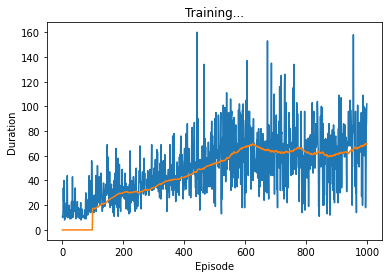

Episode 1000 
 100 episode moving avg: 69.86


In [22]:
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)

            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done:
            episode_durations.append(timestep)
            plot(episode_durations, 100)
            break
            
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

em.close()       